In [1]:
# Monte Carlo + Black-Scholes analysis for the QBTS $19 put (detailed, well-commented)
# Produces:
#  1) Put option price vs underlying stock price (grid ±10%)
#  2) Histogram of simulated net profit per contract for S = S0 (show mean & median)
#  3) EV and CE vs stock price on the same graph (CE for multiple A values)
#  4) Mean and median of profit vs stock price (and probability of profit)
# Also displays a table with key numbers for the grid (price, EV, median, Var, CE, P(win)).
#
# NOTES / choices:
#  - N (MC draws) chosen to balance accuracy and runtime/memory. Change N if you want more precision.
#  - Grid size and N are moderate: N=30000, grid G=101 -> 3.03M simulated prices (reasonable memory)
#  - IV held fixed (per your instruction). We assume selling next day (tau_sale = 1/252)
#  - Entry price = ask = 0.08 per share. Net profit per contract = 100*(resale_price - entry_price).
#
# Run-time: a few seconds; plots will appear inline.

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

In [3]:
start_time = time.time()

# ------------------- Parameters -------------------
S0 = 22.25                     # current underlying price
K = 19.0                       # strike
entry_price = 0.08             # assumed buy price at ask (per share)
premium_per_contract = entry_price * 100.0
iv_annual = 1.7392             # 173.92% IV as fraction
r = 0.0                        # risk-free rate (short horizon)
tau_sale = 1.0 / 252.0         # time remaining when we sell (1 trading day)
dt = 1.0 / 252.0               # one-day step for GBM simulation
N = 100000                      # Monte Carlo samples (adjustable)
G = 101                        # number of points in S grid (~±10% around S0)
A_values = [1e-4, 1e-3, 1e-2]  # sample absolute risk-aversion values for CE plotting


In [4]:
# ------------------- Utility: robust normal CDF :Defines a vectorized cumulative distribution function (CDF) of the standard normal.-------------------
# Try to use scipy if present (fast). Otherwise fall back to vectorized math.erf (slower but works).
try:
    from scipy.special import erf as sp_erf
    def vectorized_norm_cdf(x):
        #Returns the error function of complex argument.
        #It is defined as 2/sqrt(pi)*integral(exp(-t**2), t=0..z)
        return 0.5 * (1.0 + sp_erf(x / np.sqrt(2.0))) 
except Exception:
    def vectorized_norm_cdf(x):
        # math.erf works on scalars; use numpy.vectorize to apply to arrays
        vf = np.vectorize(math.erf)
        return 0.5 * (1.0 + vf(x / math.sqrt(2.0)))

In [5]:
# ------------------- Black-Scholes European put price (vectorized) -------------------
def bs_put_price(S, K, tau, sigma, r=0.0):
    """
    Vectorized Black-Scholes European put price per share for simulated possible future stock prices.
    S can be numpy array of any shape. Returns same-shape array.
    """
    S = np.array(S, dtype=float)
    tau = float(tau)
    if tau <= 0: #if time to expiry is zero or negative, the put is worth its intrinsic value: max(K - S, 0)
        return np.maximum(K - S, 0.0) 
    # clip S to avoid log(0); this has negligible effect in practice
    S_clip = np.maximum(S, 1e-12) #Avoid log(0)
    vol_sqrt = sigma * math.sqrt(tau) #Standard deviation of log returns over tau years. Formula comes from GBM (geometric Brownian motion).
    
    #d1 and d2 are Black-Scholes intermediates
    #They represent the standardized distance to the strike under risk-neutral probability.
    d1 = (np.log(S_clip / K) + (r + 0.5 * sigma**2) * tau) / vol_sqrt
    d2 = d1 - vol_sqrt
    Nd1 = vectorized_norm_cdf(-d1) #probability put will be exercised weighted by stock price.
    Nd2 = vectorized_norm_cdf(-d2) #probability put will be exercised weighted by discounted strike.
    
    #European put price formula: P=Ke−rτN(−d2​)−SN(−d1​)
    #First term → present value of strike weighted by probability exercised.
    # Second term → expected loss of stock weighted by probability exercised 
    P = K * math.exp(-r * tau) * Nd2 - S_clip * Nd1 
    return np.maximum(P, 0.0) #Ensures price can’t be negative.

In [6]:
# ------------------- 1) Put price vs underlying (grid ±10%) -------------------
S_min = S0 * (1.0 - ((iv_annual/2)/16)) #Assuming stock moves +/- half of what expected from IV
S_max = S0 * (1.0 + ((iv_annual/2)/16))
S_grid = np.linspace(S_min, S_max, G) #Creates a grid with sample points = G, ±half of IV move around current price
put_price_grid = bs_put_price(S_grid, K, tau_sale, iv_annual, r=r) #Calculate put price for probable stock price in S_grid

# net_profit_grid_per_share = put_price_grid - entry_price #proft per contract -- depends on your entry price which we fix above
# net_profit_grid_per_contract = net_profit_grid_per_share * 100.0

net_profit_grid_per_contract = np.full_like(S_grid, np.nan)


In [19]:
# ------------------- 2) TWO-STEP Monte Carlo: Buy Thu (1DTE), hold to Fri expiry -------------------
rng = np.random.default_rng(123456)
sigma = iv_annual

# Day 1: Wed -> Thu (spot moves to S_thu)
Z1 = rng.standard_normal(N)
M1 = np.exp((-0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * Z1)
S_thu = M1[:, None] * S_grid[None, :]          # shape (N, G)

# Entry premium on Thu: fresh 1DTE option (expires Fri)
premium_thu = bs_put_price(S_thu, K, tau_sale, iv_annual, r=r)   # shape (N, G)

# Day 2: Thu -> Fri (spot moves to S_fri)
Z2 = rng.standard_normal(N)
M2 = np.exp((-0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * Z2)
S_fri = M2[:, None] * S_thu                    # shape (N, G)

# Payoff at Fri expiry
payoff_fri = np.maximum(K - S_fri, 0.0)        # shape (N, G)

# Net profit per contract ($): payoff - premium paid on Thu
slip = 0.01  # $0.01 per share
premium_thu_effective = premium_thu + slip
net_profit_matrix = (payoff_fri - premium_thu_effective) * 100.0           # shape (N, G)

# Keep your original variable names used by plots:
S_t = S_thu
put_prices_t = premium_thu_effective


In [20]:
# ------------------- 3) Compute stats across Monte Carlo for each grid point -------------------
EV_grid = net_profit_matrix.mean(axis=0)                     # expected net profit per contract
Var_grid = net_profit_matrix.var(axis=0)                     # variance around expected net profit
Std_grid = np.sqrt(Var_grid)                                 # std around expected net profit
Median_grid = np.median(net_profit_matrix, axis=0)           #median net profit as mean can be skewed
Prob_profit_grid = (net_profit_matrix > 0.0).mean(axis=0)    # probability of positive net profit 

# Certainty equivalent(CE) CE_grid for each A in A_values, using small-variance approximation CE = EV - 0.5*A*Var
CE_grids = {}
for A in A_values:
    CE_grids[A] = EV_grid - 0.5 * A * Var_grid

# ------------------- 4) Extract S0 index results and distribution for S0 -------------------
# find index in S_grid closest to S0
idx_S0 = int(np.argmin(np.abs(S_grid - S0))) #find index of current stock price (S0) in a grid of possibl stock prices
S0_closest = S_grid[idx_S0] #current stock price may not lie in the possible swtock prices grid, so closest value available in the grid
net_profit_S0 = net_profit_matrix[:, idx_S0]   # distribution of profits if current S = S0

#Extracts distribution, mean, median, std, probability of profit for S ≈ S0
EV_S0 = EV_grid[idx_S0]
Var_S0 = Var_grid[idx_S0]
Std_S0 = Std_grid[idx_S0]
Median_S0 = Median_grid[idx_S0]
Prob_profit_S0 = Prob_profit_grid[idx_S0]


In [21]:
entry_premium_mean = premium_thu.mean(axis=0)
entry_premium_median = np.median(premium_thu, axis=0)

summary_df = pd.DataFrame({
    "S": np.round(S_grid, 2),
    "PutPrice per share (1DTE curve)": np.round(put_price_grid, 2),

    "Entry premium Thu mean": np.round(entry_premium_mean, 3),
    "Entry premium Thu median": np.round(entry_premium_median, 3),

    "EV per contract($)": np.round(EV_grid, 3),
    "Median per contract($)": np.round(Median_grid, 3),
    "Std per contract($)": np.round(Std_grid, 3),
    "Prob_profit %": np.round(Prob_profit_grid * 100.0, 2)
})

# include CE columns for each A
for A in A_values:
    summary_df[f"CE_A={A}"] = np.round(CE_grids[A], 4)


In [22]:
summary_df

,S,PutPrice per share (1DTE curve),Entry premium Thu mean,Entry premium Thu median,EV per contract($),Median per contract($),Std per contract($),Prob_profit %,CE_A=0.0001,CE_A=0.001,CE_A=0.01
0,21.04,0.21,0.473,0.230,-1.118,-9.256,81.264,19.86,-1.4485,-4.4202,-34.1373
1,21.06,0.20,0.467,0.226,-1.118,-9.138,80.838,19.72,-1.4452,-4.3859,-33.7926
2,21.09,0.20,0.462,0.222,-1.119,-9.058,80.414,19.56,-1.4420,-4.3519,-33.4508
3,21.11,0.20,0.456,0.218,-1.119,-8.959,79.991,19.39,-1.4387,-4.3181,-33.1115
4,21.14,0.19,0.451,0.214,-1.119,-8.856,79.568,19.26,-1.4353,-4.2843,-32.7742
...,...,...,...,...,...,...,...,...,...,...,...
96,23.36,0.03,0.137,0.031,-1.038,-2.796,45.560,8.23,-1.1419,-2.0760,-11.4167
97,23.39,0.03,0.135,0.030,-1.037,-2.761,45.253,8.15,-1.1393,-2.0609,-11.2760
98,23.41,0.03,0.133,0.029,-1.036,-2.726,44.947,8.05,-1.1369,-2.0460,-11.1370
99,23.44,0.02,0.131,0.028,-1.035,-2.692,44.642,7.95,-1.1343,-2.0311,-10.9993


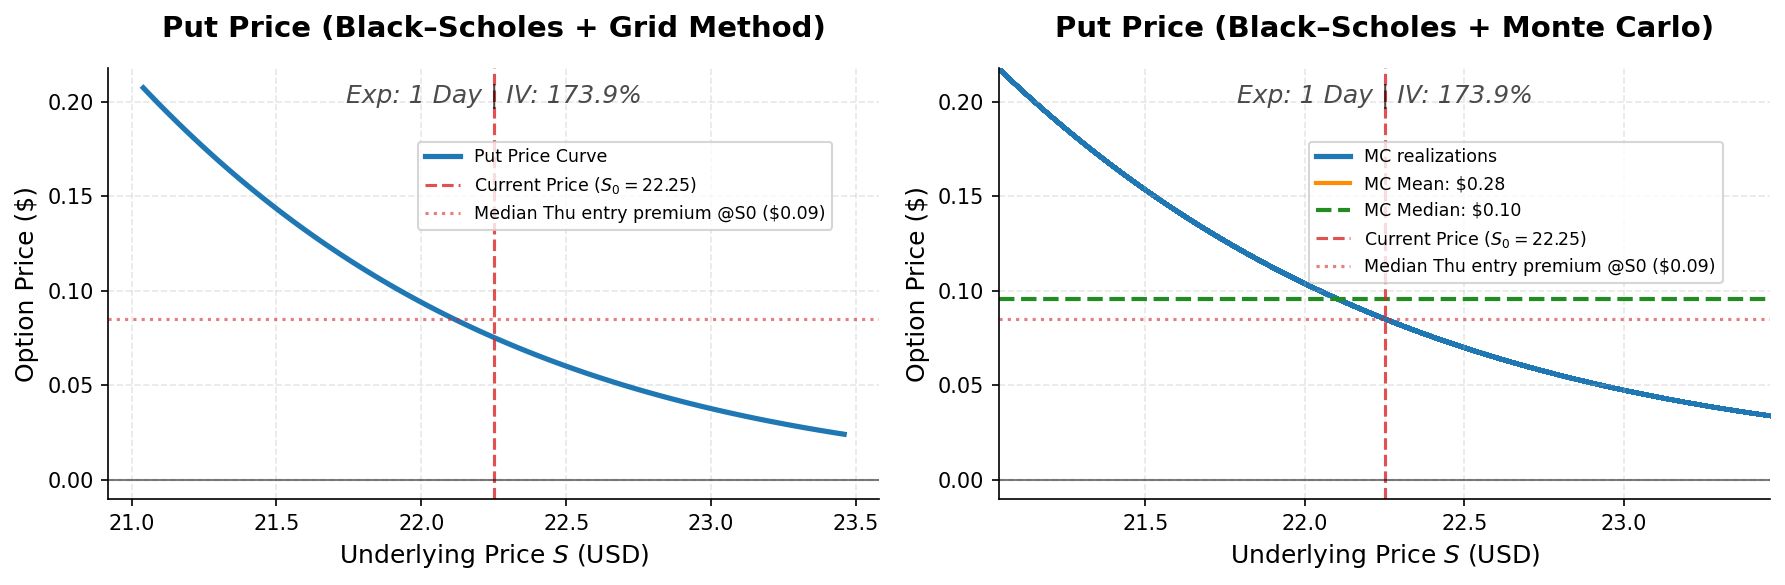

In [23]:
import matplotlib.pyplot as plt

# ------------------- 6) Visualizations (Enhanced for Blog) -------------------
# Using a clean style and high DPI for saving
plt.style.use('seaborn-v0_8-muted') # Or 'ggplot' / 'bmh'
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
ax = ax.ravel()

# Common styling parameters
line_color = '#1f77b4' # Sophisticated blue
highlight_color = '#d62728' # Professional red for S0
grid_alpha = 0.3

# --- Plot 1: Finite Difference / Grid Method ---
ax[0].plot(S_grid, put_price_grid, color=line_color, lw=2.5, label='Put Price Curve')
ax[0].set_title("Put Price (Black–Scholes + Grid Method)", fontsize=14, fontweight='bold', pad=15)
ax[0].set_ylabel("Option Price ($)", fontsize=12)

# --- Plot 2: Monte Carlo Simulation ---
# Increased alpha and point size for a "cloud" effect
ax[1].scatter(S_t.flatten()[::(N*G)//500000], 
              put_prices_t.flatten()[::(N*G)//500000], 
              alpha=0.1, s=1, color=line_color)
ax[1].plot(S_grid, np.nan * put_price_grid, color=line_color, lw=2.5, label='MC realizations')
ax[1].set_title("Put Price (Black–Scholes + Monte Carlo)", fontsize=14, fontweight='bold', pad=15)
ax[1].set_ylabel("Option Price ($)", fontsize=12)

mc_mean = np.mean(put_prices_t)
mc_median = np.median(put_prices_t)

ax[1].axhline(y=mc_mean, color='darkorange', lw=2, ls='-', label=f'MC Mean: ${mc_mean:.2f}')
ax[1].axhline(y=mc_median, color='forestgreen', lw=2, ls='--', label=f'MC Median: ${mc_median:.2f}')

# --- Universal Adjustments (Applied to both) ---
for i in range(2):
    ax[i].set_xlabel("Underlying Price $S$ (USD)", fontsize=12)
    ax[i].grid(True, linestyle='--', alpha=grid_alpha)
    
    # Visual cues for S0 and Entry Price
    ax[i].axvline(S0, color=highlight_color, linestyle='--', alpha=0.8, label=f'Current Price ($S_0={S0}$)')
    
    entry_premium_S0_median = np.median(premium_thu[:, idx_S0])
    
    ax[i].axhline(y=entry_premium_S0_median, color=highlight_color, linestyle=':', alpha=0.6, 
                  label=f'Median Thu entry premium @S0 (${entry_premium_S0_median:.2f})')
    ax[i].axhline(y=0, color='black', lw=1, alpha=0.5) # Zero line
    
    # Cleanup spines for aesthetic
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    # Subtitle with parameters
    ax[i].text(0.5, 0.92, f"Exp: 1 Day | IV: {iv_annual:.1%}", 
               transform=ax[i].transAxes, ha='center', fontsize=12, style='italic', alpha=0.7)
    
    ax[i].legend(fontsize='small', loc='upper right', frameon=True, facecolor='white', framealpha=0.8, 
                 bbox_to_anchor=(0.95,0.85))

# Match axes for direct comparison
ax[1].set_xlim(S_grid.min(), S_grid.max())
ax[1].set_ylim(ax[0].get_ylim())
# ax[1].set_ylim(0.0,0.30)
# ax[0].set_ylim(0.0,0.30)
plt.tight_layout()

# Save for blog - transparent background and high DPI
#plt.savefig('option_valuation_comparison.png', dpi=300, bbox_inches='tight', transparent=False)
#plt.show()

(-18.0, 100.0)

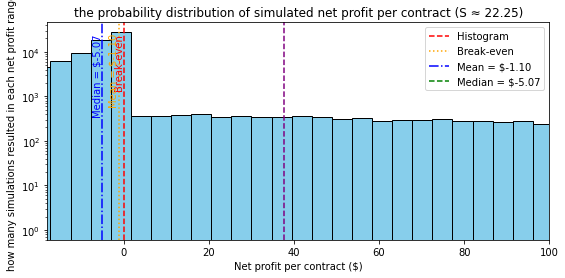

In [24]:
# Histogram of simulated net profit for S0 (single plot)
plt.figure(figsize=(9,4))
plt.hist(net_profit_S0, bins=200, color='skyblue', edgecolor='black')
plt.axvline(0.0, color='red', linestyle='--', label='Break-even')
plt.axvline(EV_S0, color='orange', linestyle=':', label=f'Mean = ${EV_S0:.2f}')
plt.axvline(Median_S0, color='blue', linestyle='-.', label=f'Median = ${Median_S0:.2f}')

plt.axvline(np.percentile(net_profit_S0, 10), color='green', linestyle='--', label=f'10th pct = ${np.percentile(net_profit_S0, 10):.2f}')
plt.axvline(np.percentile(net_profit_S0, 90), color='purple', linestyle='--', label=f'90th pct = ${np.percentile(net_profit_S0, 90):.2f}')

# Text annotations
plt.text(0.0, plt.ylim()[1]*0.9, "Break-even", color='red', rotation=90, va='top', ha='right')
plt.text(EV_S0, plt.ylim()[1]*0.9, f"Mean = ${EV_S0:.2f}", color='orange', rotation=90, va='top', ha='right')
plt.text(Median_S0, plt.ylim()[1]*0.9, f"Median = ${Median_S0:.2f}", color='blue', rotation=90, va='top', ha='right')

plt.xlabel("Net profit per contract ($)")
plt.ylabel("how many simulations resulted in each net profit range")
plt.title(f"the probability distribution of simulated net profit per contract (S ≈ {S0_closest})")
plt.legend(["Histogram", "Break-even", f"Mean = ${EV_S0:.2f}", f"Median = ${Median_S0:.2f}"])
plt.yscale('log')
plt.xlim(-entry_price*100 - 10,100)


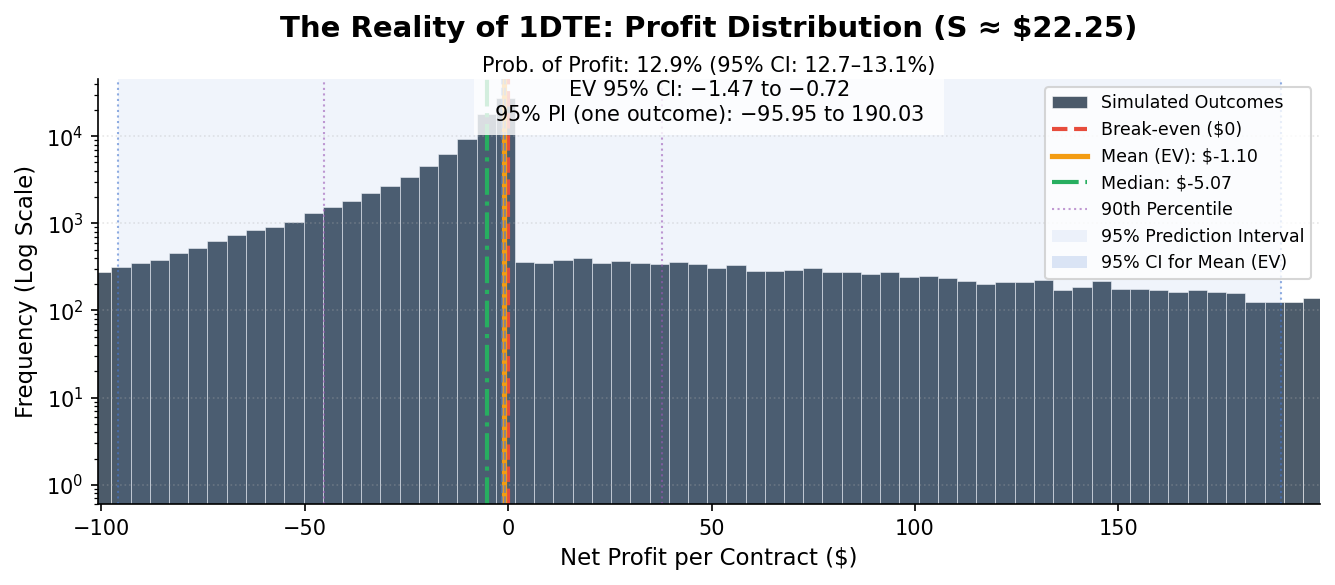

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# --- 20) Profit/Loss Histogram (Enhanced for Blog Aesthetic) ---
plt.style.use('seaborn-v0_8-muted')
fig, ax = plt.subplots(figsize=(9, 4), dpi=150)

# 1. Plotting the Histogram with a professional "Steel Blue"
# Using a log scale highlights the rare 'big wins' in the tail
counts, bins, patches = ax.hist(net_profit_S0, bins=200, color='#2c3e50', 
                                edgecolor='white', linewidth=0.3, alpha=0.85, label='Simulated Outcomes')

# 2. Statistical Markers
# Break-even is the most important psychological line
ax.axvline(0.0, color='#e74c3c', lw=2, linestyle='--', label='Break-even ($0)')

# Mean and Median (Visualizing the Skew)
ax.axvline(EV_S0, color='#f39c12', lw=2.5, linestyle='-', label=f'Mean (EV): ${EV_S0:.2f}')
ax.axvline(Median_S0, color='#27ae60', lw=2, linestyle='-.', label=f'Median: ${Median_S0:.2f}')

# 10th/90th Percentiles (The "Realistic" Range)
p10, p90 = np.percentile(net_profit_S0, 10), np.percentile(net_profit_S0, 90)
ax.axvline(p10, color='#9b59b6', lw=1, linestyle=':', alpha=0.6)
ax.axvline(p90, color='#9b59b6', lw=1, linestyle=':', alpha=0.6, label='90th Percentile')

net_profit_S0_size = net_profit_S0.size
# --- 95% Prediction Interval (range for ONE future outcome) ---
pi_low, pi_high = np.percentile(net_profit_S0, [2.5, 97.5])

# --- 95% Confidence Interval for the MEAN (EV) (uncertainty in estimated EV from finite sims) ---
EV_hat = net_profit_S0.mean()
net_profit_S0_std = net_profit_S0.std(ddof=1)

zval = 1.96  # normal approx; fine for large n
ci_ev_low = EV_hat - zval * net_profit_S0_std / np.sqrt(net_profit_S0_size)
ci_ev_high = EV_hat + zval * net_profit_S0_std / np.sqrt(net_profit_S0_size)

# --- 95% CI for Probability of Profit (Wilson interval; better than plain +/-) ---
kwil = np.sum(net_profit_S0 > 0)
p_hat = kwil / net_profit_S0_size

den = 1 + zval**2 / net_profit_S0_size
center = (p_hat + zval**2 / (2*net_profit_S0_size)) / den
half = zval * np.sqrt((p_hat*(1-p_hat) + zval**2/(4*net_profit_S0_size)) / net_profit_S0_size) / den
ci_p_low, ci_p_high = center - half, center + half

# 95% prediction interval shading + lines
ax.axvspan(pi_low, pi_high, alpha=0.08, label='95% Prediction Interval')
ax.axvline(pi_low, lw=1, linestyle=':', alpha=0.6)
ax.axvline(pi_high, lw=1, linestyle=':', alpha=0.6)

# 95% confidence interval for EV (narrow band around the mean)
ax.axvspan(ci_ev_low, ci_ev_high, alpha=0.18, label='95% CI for Mean (EV)')
ax.axvline(ci_ev_low, lw=1, linestyle='--', alpha=0.6)
ax.axvline(ci_ev_high, lw=1, linestyle='--', alpha=0.6)

# Update your annotation to include the interval info (optional)
ax.text(
    0.5, 0.90,
    f"Prob. of Profit: {p_hat*100:.1f}% (95% CI: {ci_p_low*100:.1f}–{ci_p_high*100:.1f}%)\n"
    f"EV 95% CI: ${ci_ev_low:.2f}$ to ${ci_ev_high:.2f}$\n"
    f"95% PI (one outcome): ${pi_low:.2f}$ to ${pi_high:.2f}$",
    transform=ax.transAxes, ha='center', fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)


# 3. Informative Annotations (Avoid Overlap)
y_max = ax.get_ylim()[1]
# ax.text(0.5, 0.95, f"Probability of Profit: {Prob_profit_S0*100:.1f}%", 
#         transform=ax.transAxes, ha='center', fontsize=12, fontweight='bold', 
#         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# 4. Final Formatting
ax.set_yscale('log')
ax.set_xlabel("Net Profit per Contract ($)", fontsize=11)
ax.set_ylabel("Frequency (Log Scale)", fontsize=11)
ax.set_title(f"The Reality of 1DTE: Profit Distribution (S ≈ ${S0_closest:.2f})", 
             fontsize=14, fontweight='bold', pad=20)

# Set X-limits based on your entry price to center the data
ax.set_xlim(pi_low * 1.05, pi_high * 1.05)

# Clean up layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle=':', alpha=0.3)
ax.legend(loc='upper right', frameon=True, fontsize='small')

plt.tight_layout()
plt.savefig('profit_distribution_blog.png', dpi=300)
plt.show()

Observations from your histogram

    Distribution is heavily skewed left: 
        a) Most of the profits are negative (to the left of 0).
        
        b) There is a long tail of positive outcomesBreak-even (red line):

    Very few simulations are above break-even → low probability of making a profit.

    Mean vs Median:

        a) Mean ($13.92, orange line) is positive, but median ($-1.29, blue line) is negative.

        b) This indicates the distribution is right-skewed: most outcomes are small losses, a few big wins pull the average above zero.

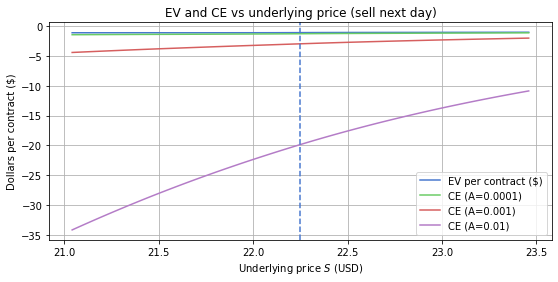

In [26]:
# EV and multiple CE curves vs S grid on same graph
plt.figure(figsize=(9,4))
plt.plot(S_grid, EV_grid, label="EV per contract ($)")
for A in A_values:
    plt.plot(S_grid, CE_grids[A], label=f"CE (A={A})")
plt.xlabel("Underlying price $S$ (USD)")
plt.ylabel("Dollars per contract ($)")
plt.title("EV and CE vs underlying price (sell next day)")
plt.grid(True)
plt.legend()
plt.axvline(S0, linestyle='--')
plt.show()

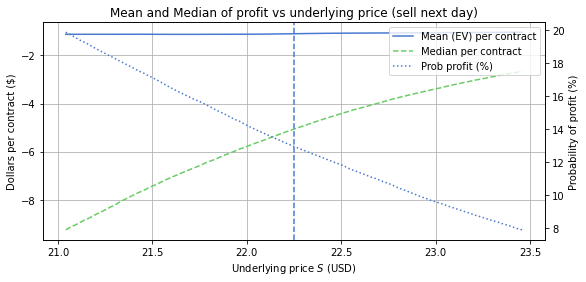

In [27]:
# Mean and median vs S grid + probability-of-profit (secondary axis)
plt.figure(figsize=(9,4))
plt.plot(S_grid, EV_grid, label="Mean (EV) per contract")
plt.plot(S_grid, Median_grid, linestyle='--', label="Median per contract")
ax = plt.gca()
ax.set_xlabel("Underlying price $S$ (USD)")
ax.set_ylabel("Dollars per contract ($)")
ax.set_title("Mean and Median of profit vs underlying price (sell next day)")
ax.grid(True)
ax.axvline(S0, linestyle='--')
# secondary axis for probability of profit
ax2 = ax.twinx()
ax2.plot(S_grid, Prob_profit_grid * 100.0, linestyle=':', label="Prob profit (%)")
ax2.set_ylabel("Probability of profit (%)")
# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')
plt.show()

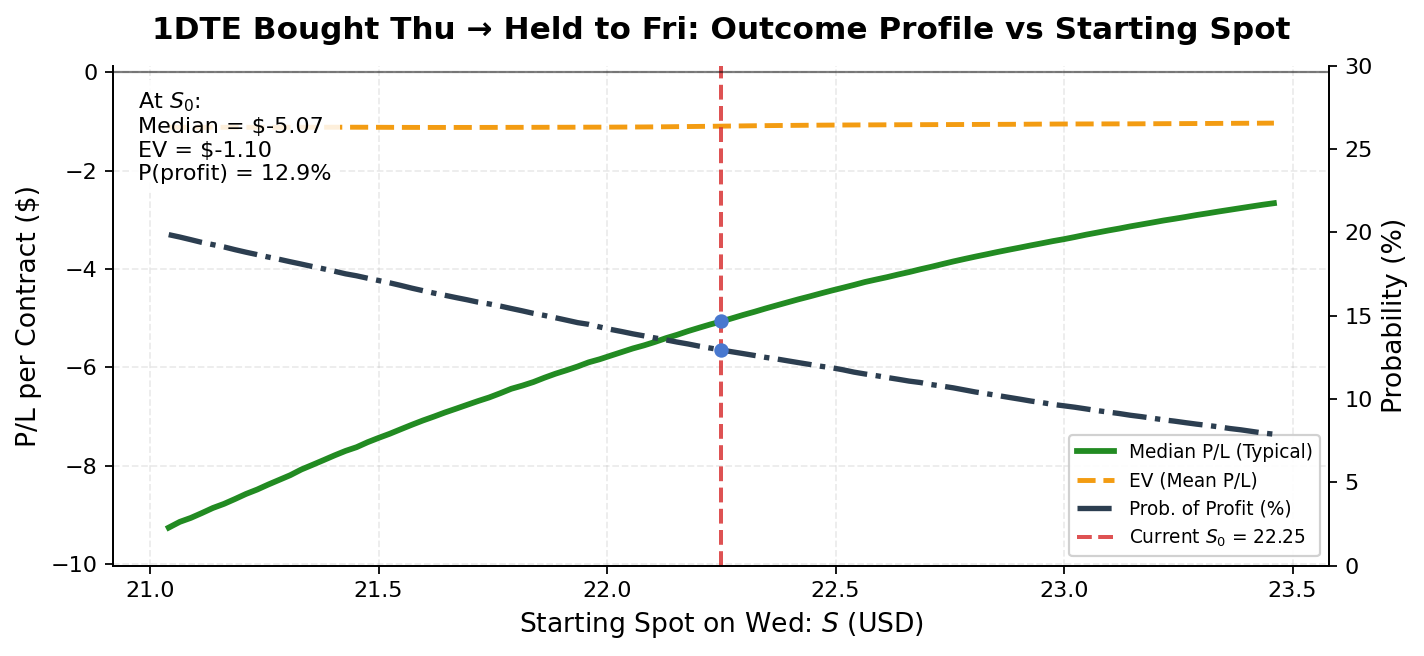

In [42]:
plt.style.use('seaborn-v0_8-muted')

fig, ax1 = plt.subplots(figsize=(9, 4.2), dpi=160)
ax2 = ax1.twinx()

# --- Lines (left axis: $ P/L per contract) ---
l_med, = ax1.plot(S_grid, Median_grid, lw=2.6, label='Median P/L (Typical)',c='forestgreen')
l_ev,  = ax1.plot(S_grid, EV_grid,     lw=2.2, ls='--', label='EV (Mean P/L)',color='#f39c12')

# --- Line (right axis: probability %) ---
l_prob, = ax2.plot(S_grid, 100.0 * Prob_profit_grid, lw=2.4, ls='-.',color='#2c3e50',
                   label='Prob. of Profit (%)')

# --- Reference cues ---
ax1.axvline(S0, lw=1.8, ls='--', alpha=0.8, label=f'Current $S_0$ = {S0:.2f}',color=highlight_color)
ax1.axhline(0.0, color='black', lw=1.0, alpha=0.5)

# --- Labels / Titles ---
ax1.set_title("1DTE Bought Thu → Held to Fri: Outcome Profile vs Starting Spot",
              fontsize=14, fontweight='bold', pad=12)
ax1.set_xlabel("Starting Spot on Wed: $S$ (USD)", fontsize=12)
ax1.set_ylabel("P/L per Contract ($)", fontsize=12)
ax2.set_ylabel("Probability (%)", fontsize=12)

# --- Axis hygiene ---
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(True, linestyle='--', alpha=0.25)

# --- Sensible y-limits ---
# left axis: set symmetric-ish around typical values
yl = np.nanpercentile(np.r_[EV_grid, Median_grid], [2, 98])
pad = 0.15 * (yl[1] - yl[0] + 1e-9)
ax1.set_ylim(yl[0] - pad, yl[1] + pad)

ax2.set_ylim(0, min(100, max(30, np.nanmax(100*Prob_profit_grid)*1.2)))

# --- Annotation at S0 ---
ev0 = EV_grid[idx_S0]
med0 = Median_grid[idx_S0]
p0 = 100.0 * Prob_profit_grid[idx_S0]

ax1.scatter([S0], [med0], s=30, zorder=4)
ax2.scatter([S0], [p0],   s=30, zorder=4)

ax1.text(
    0.02, 0.95,
    f"At $S_0$:\nMedian = ${med0:.2f}\nEV = ${ev0:.2f}\nP(profit) = {p0:.1f}%",
    transform=ax1.transAxes, va='top', fontsize=10,
    bbox=dict(facecolor='white', alpha=0.85, edgecolor='none')
)

# --- Unified legend (combine both axes) ---
handles = [l_med, l_ev, l_prob]
labels  = [h.get_label() for h in handles]
# add S0 line and zero line label via ax1 legend handles
h1, lab1 = ax1.get_legend_handles_labels()
handles = handles + [h for h,lab in zip(h1,lab1) if "Current" in lab]
labels  = labels  + [lab for lab in lab1 if "Current" in lab]

ax1.legend(handles, labels, loc='lower right', fontsize='small',
           frameon=True, facecolor='white', framealpha=0.9)

plt.tight_layout()
plt.savefig('strategy_profile_vs_spot.png', dpi=300, bbox_inches='tight')
plt.show()


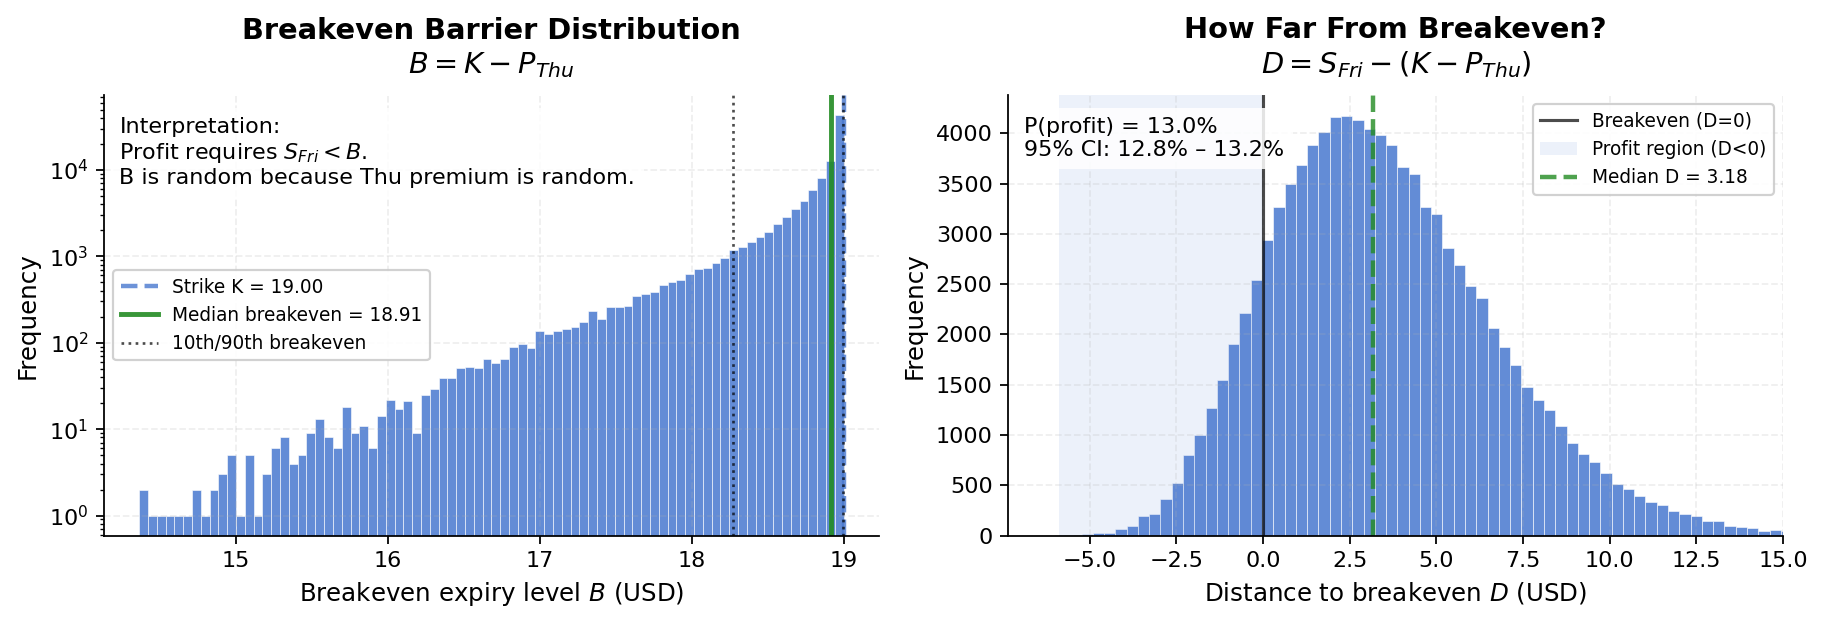

In [57]:
plt.style.use('seaborn-v0_8-muted')

# Use the S0 column (strategy as of current spot)
prem_S0 = premium_thu[:, idx_S0]          # per share premium you pay Thu
B = K - prem_S0                           # breakeven barrier at expiry (per path)
Sfri_S0 = S_fri[:, idx_S0]                # expiry spot (per path)
D = Sfri_S0 - B                           # distance-to-breakeven; profit iff D < 0

p_profit = np.mean(D < 0)

# Optional: Wilson CI for p_profit (nice blog touch)
n = D.size
z = 1.96
ph = p_profit
den = 1 + z**2 / n
center = (ph + z**2/(2*n)) / den
half = z * np.sqrt((ph*(1-ph) + z**2/(4*n)) / n) / den
ci_lo, ci_hi = center - half, center + half

fig, ax = plt.subplots(1, 2, figsize=(11.5, 4.0), dpi=160)
ax = ax.ravel()

# --- Panel A: Breakeven barrier B = K - premium_thu ---
binsA = 80
ax[0].hist(B, bins=binsA, alpha=0.85, edgecolor='white', linewidth=0.3)
b_med = np.median(B)
b10, b90 = np.percentile(B, [10, 90])

ax[0].axvline(K, lw=2.0, ls='--', alpha=0.8, label=f"Strike K = {K:.2f}")
ax[0].axvline(b_med, lw=2.2, ls='-', alpha=0.9, label=f"Median breakeven = {b_med:.2f}",c='forestgreen')
ax[0].axvline(b10, lw=1.2, ls=':', alpha=0.7,c='k')
ax[0].axvline(b90, lw=1.2, ls=':', alpha=0.7, label="10th/90th breakeven",c='k')

ax[0].set_title("Breakeven Barrier Distribution\n$B = K - P_{Thu}$", fontsize=13, fontweight='bold', pad=10)
ax[0].set_xlabel("Breakeven expiry level $B$ (USD)", fontsize=11)
ax[0].set_ylabel("Frequency", fontsize=11)
ax[0].grid(True, linestyle='--', alpha=0.2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].text(
    0.02, 0.95,
    f"Interpretation:\nProfit requires $S_{{Fri}} < B$.\n"
    f"B is random because Thu premium is random.",
    transform=ax[0].transAxes, va='top', fontsize=10,
    bbox=dict(facecolor='white', alpha=0.85, edgecolor='none')
)

ax[0].legend(loc='center left', fontsize='small', frameon=True,
             facecolor='white', framealpha=0.9)

ax[0].set_yscale('log')

# --- Panel B: Distance-to-breakeven D = S_fri - B ---
binsB = 90
ax[1].hist(D, bins=binsB, alpha=0.85, edgecolor='white', linewidth=0.3)

ax[1].axvline(0.0, color='black', lw=1.4, alpha=0.7, label="Breakeven (D=0)")
# shade profit region
ax[1].axvspan(np.min(D), 0.0, alpha=0.10, label="Profit region (D<0)")

d_med = np.median(D)
ax[1].axvline(d_med, lw=2.0, ls='--', alpha=0.8, label=f"Median D = {d_med:.2f}", c='forestgreen')

ax[1].set_title("How Far From Breakeven?\n$D = S_{Fri} - (K - P_{Thu})$", fontsize=13, fontweight='bold', pad=10)
ax[1].set_xlabel("Distance to breakeven $D$ (USD)", fontsize=11)
ax[1].set_ylabel("Frequency", fontsize=11)
ax[1].grid(True, linestyle='--', alpha=0.2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].text(
    0.02, 0.95,
    f"P(profit) = {100*p_profit:.1f}%\n"
    f"95% CI: {100*ci_lo:.1f}% – {100*ci_hi:.1f}%",
    transform=ax[1].transAxes, va='top', fontsize=10,
    bbox=dict(facecolor='white', alpha=0.85, edgecolor='none')
)

ax[1].set_xlim(ax[1].get_xlim()[0],15)
ax[1].legend(loc='upper right', fontsize='small', frameon=True,
             facecolor='white', framealpha=0.9)

plt.tight_layout()
plt.savefig('breakeven_barrier.png', dpi=300, bbox_inches='tight')
plt.show()


In [47]:
b10,b90

(18.272109402303972, 18.99715254202781)